In [3]:
import os
import pickle
from keras_facenet import FaceNet
import cv2
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import imgaug.augmenters as iaa
import sys
import contextlib

# Suppress output Keras
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout


In [ ]:
# ----- SETTING PATH -----
base_dir = '/home/wgg/Tubes_AI/dataset3'   # Folder dataset
pkl_path = '/home/wgg/Tubes_AI/HASIL_FACENET/knn_facenet_aug3.pkl'  # Output model

embedder = FaceNet()
X, y = [], []

# Augmentasi: flip, rotasi, brightness, blur, hue
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-10, 10)),
    iaa.Multiply((0.8, 1.2)),
    iaa.AddToHueAndSaturation((-10, 10)),
    iaa.GaussianBlur(sigma=(0, 1.0)),
])

# Proses ekstraksi embedding + augmentasi
for label in os.listdir(base_dir):
    folder = os.path.join(base_dir, label)
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (160, 160))
        with suppress_stdout():
            emb = embedder.embeddings([img])[0]
        X.append(emb)
        y.append(label)
        for _ in range(3):  # augmentasi 3x per gambar
            aug_img = seq(image=img)
            with suppress_stdout():
                aug_emb = embedder.embeddings([aug_img])[0]
            X.append(aug_emb)
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Total data setelah augmentasi:", X.shape, y.shape)

# Training KNN
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(X, y)

# Simpan model
with open(pkl_path, 'wb') as f:
    pickle.dump(knn, f)
print(f"Model KNN berhasil disimpan di: {pkl_path}")

2025-06-17 01:40:40.461624: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-17 01:40:40.461663: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wgg-OMEN-by-HP-Laptop-15-dc1xxx): /proc/driver/nvidia/version does not exist
2025-06-17 01:40:40.462067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Total data setelah augmentasi: (1136, 512) (1136,)
Model KNN berhasil disimpan di: /home/wgg/Tubes_AI/HASIL_FACENET/knn_facenet_aug2.pkl


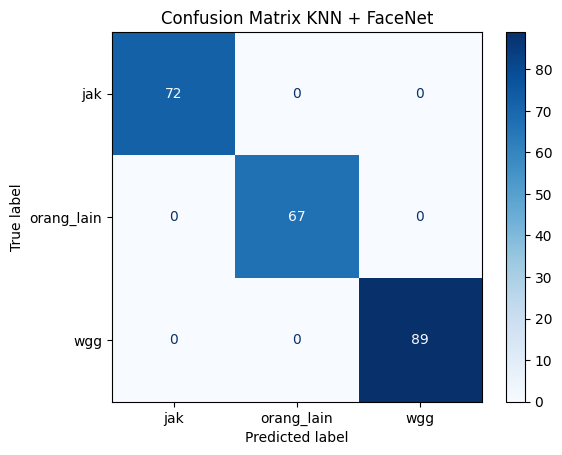

Classification Report:
               precision    recall  f1-score   support

         jak       1.00      1.00      1.00        72
  orang_lain       1.00      1.00      1.00        67
         wgg       1.00      1.00      1.00        89

    accuracy                           1.00       228
   macro avg       1.00      1.00      1.00       228
weighted avg       1.00      1.00      1.00       228

Akurasi test set: 100.00%


In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Split manual: 80% train, 20% test (atau sesuai kebutuhan)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(X_train, y_train)

# Prediksi test
y_pred = knn.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix KNN + FaceNet')
plt.show()

# Classification report & akurasi
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Akurasi test set: {:.2f}%".format(knn.score(X_test, y_test)*100))
